In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 4.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.18.0 requires google-genai<2.0.0,>=1.45.0, but you have google-genai 1.7.0 which is incompatible.
google-cloud-aiplatform 1.125.0 requires google-genai<2.0.0,>=1.37.0, but you have google-genai 1.7.0 which is incompatible.


In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

Let's try to search without providing grounding

In [7]:
from IPython.display import Markdown, HTML, display

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, I don't have access to real-time information about Billie Eilish's concert schedule. Concert dates are always subject to change, and I don't want to provide you with potentially outdated or inaccurate information.

However, here's how you can find the most up-to-date information about her tour dates:

*   **Billie Eilish's Official Website:** This is the best place to find the most accurate and current tour dates. Look for a "Tour" or "Events" section.
*   **Ticketmaster or Other Ticketing Websites:** Major ticketing platforms like Ticketmaster, Live Nation, etc., will list her upcoming concerts.
*   **Follow Billie Eilish on Social Media:** Check her official Instagram, Twitter/X, and Facebook pages. She usually announces tour dates there.



Now let's provide grounding and search the same query again

In [35]:
search_config = types.GenerateContentConfig(
    tools = [types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding(query):
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=query,
        config=search_config
    )

    return response.candidates[0]

In [36]:
query = "When and where is Billie Eilish's next concert?"

resp = query_with_grounding(query)
print(resp.content.parts[0].text)

Billie Eilish has upcoming concerts on November 22nd and 23rd, 2025, at the Chase Center in San Francisco, CA. The performances start at 7:00 PM. She is currently on her "Hit Me Hard and Soft" tour.



In [40]:
dir(resp)

['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_on_complete__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_setattr_handlers__', '__pydantic_

In [52]:
dir(resp.grounding_metadata)

['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_on_complete__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_setattr_handlers__', '__pydantic_

In [60]:
resp.grounding_metadata.grounding_chunks[0].web.title

'livenation.com'

In [64]:
# if grounding information is not returned, rerun the query
if not resp.grounding_metadata.grounding_supports or not resp.grounding_metadata.grounding_chunks:
    resp = query_with_grounding(query)

# print the source and url
for chunk in resp.grounding_metadata.grounding_chunks:
    print(f"Title: {chunk.web.title} \nurl: {chunk.web.uri}")

Title: livenation.com 
url: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH0aNldB92CwjLwjx7kf5b9Ew9a7Jdl4s-_VDLxjeotj1g-2THlAWL8XkbTYqzEeJ_qgaJegZpdPrhIryMjVinn1cnYKWX1VXYyC1Q4ACPyRVSTYWyBz8bf0DICd604RTyGsh4P-mUGKFKOaGy2vFGna0dqNmkg1jTlVXa5Tw==
Title: ticketmaster.com 
url: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHRvgwdG7614PDn8HP34YrVR8uYDkHjKj_wSYwy9yqxBJ0I55Y7oLaKxv2D3ft18mgkc2j7f4OB06RBotnKgvi-vhlDtLPpmPp7JYkpQjFpmIRMpk40DV3zENr2ufpvYpP6Ak5zmcw9Mdw2KmwN0Z7OqknT31_fAkC9nLAB
Title: vividseats.com 
url: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH7bMe9RBJFN7qqm5GEHfYpOZ9tt-Bhg3md_w-MUf-2FzXRErdq83BtQJxePeRGAe0reO2RFeuU-G0fsxPmpL5aVAjhfZW95NeDAfOAcEncccn2YEM7L2OzTgKKd6Wek2vKVZjOcd6wJSq5UCW794PAKC0KNGmnLw82COU=
Title: seatgeek.com 
url: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHRpqxemM_JoAIggpue8z1lyDKTwGNkEr9RToJCKUqTc2X7u2yf1FCqzF6ook0rmjglKe_ccCdjrCpdoiQRzh82WYWeypt4tNojnDyreCumA

In [65]:
HTML(resp.grounding_metadata.search_entry_point.rendered_content)

In [66]:
supports = resp.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.89567333, 0.9416728, 0.7751218, 0.6845389],
 'grounding_chunk_indices': [0, 1, 2, 3],
 'segment': {'end_index': 109,
             'text': 'Billie Eilish has upcoming concerts on November 22nd and '
                     '23rd, 2025, at the Chase Center in San Francisco, CA'}}
{'confidence_scores': [0.010732966, 0.6393799],
 'grounding_chunk_indices': [1, 3],
 'segment': {'end_index': 144,
             'start_index': 111,
             'text': 'The performances start at 7:00 PM'}}
{'confidence_scores': [0.75629824, 0.68698967, 0.016919369, 0.77247006],
 'grounding_chunk_indices': [2, 4, 1, 0],
 'segment': {'end_index': 197,
             'start_index': 146,
             'text': 'She is currently on her "Hit Me Hard and Soft" tour'}}


In [70]:
import io

chunks = resp.grounding_metadata.grounding_chunks
markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        resp.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish has upcoming concerts on November 22nd and 23rd, 2025, at the Chase Center in San Francisco, CA<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup><sup>[4]</sup>

 * The performances start at 7:00 PM<sup>[2]</sup><sup>[4]</sup>

 * She is currently on her "Hit Me Hard and Soft" tour<sup>[3]</sup><sup>[5]</sup><sup>[2]</sup><sup>[1]</sup>

Citations:

1. [livenation.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH0aNldB92CwjLwjx7kf5b9Ew9a7Jdl4s-_VDLxjeotj1g-2THlAWL8XkbTYqzEeJ_qgaJegZpdPrhIryMjVinn1cnYKWX1VXYyC1Q4ACPyRVSTYWyBz8bf0DICd604RTyGsh4P-mUGKFKOaGy2vFGna0dqNmkg1jTlVXa5Tw==)
2. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHRvgwdG7614PDn8HP34YrVR8uYDkHjKj_wSYwy9yqxBJ0I55Y7oLaKxv2D3ft18mgkc2j7f4OB06RBotnKgvi-vhlDtLPpmPp7JYkpQjFpmIRMpk40DV3zENr2ufpvYpP6Ak5zmcw9Mdw2KmwN0Z7OqknT31_fAkC9nLAB)
3. [vividseats.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH7bMe9RBJFN7qqm5GEHfYpOZ9tt-Bhg3md_w-MUf-2FzXRErdq83BtQJxePeRGAe0reO2RFeuU-G0fsxPmpL5aVAjhfZW95NeDAfOAcEncccn2YEM7L2OzTgKKd6Wek2vKVZjOcd6wJSq5UCW794PAKC0KNGmnLw82COU=)
4. [seatgeek.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHRpqxemM_JoAIggpue8z1lyDKTwGNkEr9RToJCKUqTc2X7u2yf1FCqzF6ook0rmjglKe_ccCdjrCpdoiQRzh82WYWeypt4tNojnDyreCumAZS5mR1M-TiSIAfvWNTNtvmbVQ9KsA==)
5. [billieeilishtickets.us](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEWDIzS4vUyxHwtId9EuR0PlyLVZ-Gq3O5n8zA_d6WhoGcoKbcGiHf3EgXcnPo6pgLAtbp263B3F9Lrw9adf0U0AXuhDuowkKRit6x9NKS3WV6JZbPJv1JecRc=)


In [71]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [72]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here are the top 10 countries by medal tally at the 2024 Paris Olympics:

1.  United States: 40 Gold, 44 Silver, 42 Bronze, 126 Total
2.  China: 40 Gold, 27 Silver, 24 Bronze, 91 Total
3.  Japan: 20 Gold, 12 Silver, 13 Bronze, 45 Total
4.  Australia: 18 Gold, 19 Silver, 16 Bronze, 53 Total
5.  France: 16 Gold, 26 Silver, 22 Bronze, 64 Total
6.  Netherlands: 15 Gold, 7 Silver, 12 Bronze, 34 Total
7.  Great Britain: 14 Gold, 22 Silver, 29 Bronze, 65 Total
8.  South Korea: 13 Gold, 9 Silver, 10 Bronze, 32 Total
9.  Italy: 12 Gold, 13 Silver, 15 Bronze, 40 Total
10. Germany: 12 Gold, 13 Silver, 8 Bronze, 33 Total



----

Okay, I can help you visualize this data using a Seaborn chart. I'll create a bar chart showing the medal breakdown (Gold, Silver, Bronze) for each of the top 10 countries.



----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data from the previous response\ndata = {\n    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'South Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8],\n    'Total': [126, 91, 45, 53, 64, 34, 65, 32, 40, 33]\n}\n\ndf = pd.DataFrame(data)\n\n# Melt the dataframe to have a column for medal type\ndf_melted = df.melt(id_vars='Country', value_vars=['Gold', 'Silver', 'Bronze'], var_name='Medal', value_name='Count')\n\n# Create the bar chart\nplt.figure(figsize=(14, 8))  # Adjust figure size for better readability\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32'])  # Use standard medal colors\nplt.title('2024 Olympics Medal Tally (

----

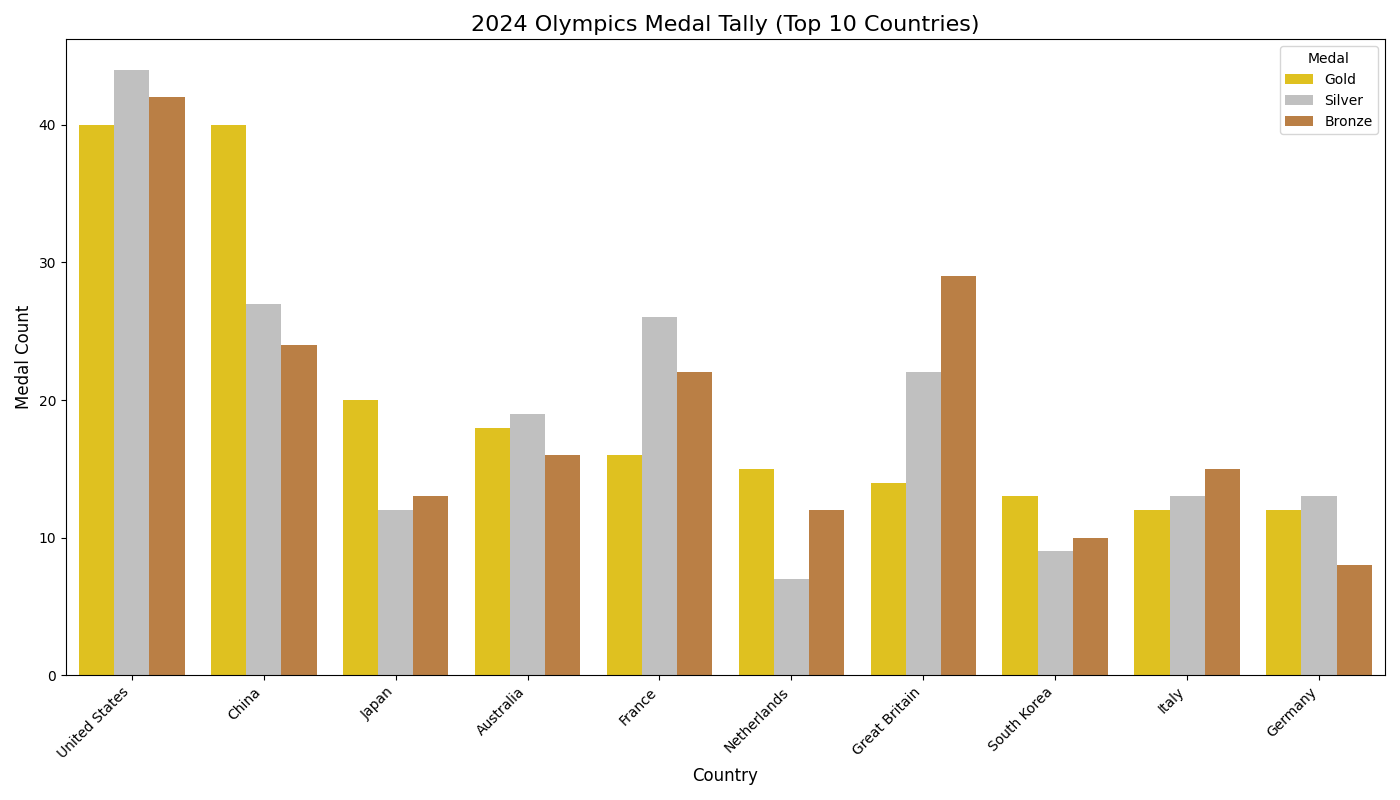

----

The bar chart visualizes the medal distribution for the top 10 countries at the 2024 Olympics. Each country has three bars representing the number of Gold, Silver, and Bronze medals won. The chart makes it easy to compare the medal counts across different countries and medal types.


----

In [73]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)